In [1]:
import os
import numpy as np
import tensorflow as tf
from models import NVAE
from datasets import load_coco
from helper_functions2 import make_gallery, draw2
from helper_functions2 import make_img, plot_loss3, plot_loss7, draw3

In [2]:
image_shape = 128
use_all_data = False

max_epoch = 500                 # Max Epochs
batch_size = 100                 # Batch size
lr = 0.01                      # Initial learning rate

n_encoder_channels = 16         # Number of initial channels in encoder
n_decoder_channels = 16         # Number of initial channels in decoder

res_cells_per_group = 2         # Number of residual cells to use within each group

n_preprocess_blocks = 2         # Number of blocks to use in the preprocessing layers
n_preprocess_cells = 3          # Number of cells to use within each preprocessing block

n_postprocess_blocks = 2        # Number of blocks to use in the postprocessing layers
n_postprocess_cells = 3         # Number of cells to use within each postprocessing block

n_latent_per_group = 20         # Number of latent stochastic variables to sample in each group
n_groups_per_scale = [5, 10]    # Number of groups to include in each resolution scale

sr_lambda = 0.01                 # Spectral regularisation strength
scale_factor = 2                # Factor to rescale image with in each scaling step
step_based_warmup = False       # Base warmup on batches trained instead of epochs

use_multigpu = False
drop_remain = False
dataset = 'coco'

In [3]:
if use_multigpu:
    strategy = tf.distribute.MirroredStrategy()
    print ('\nNumber of devices: {}'.format(strategy.num_replicas_in_sync), flush=True)

    GLOBAL_BATCH_SIZE = batch_size * strategy.num_replicas_in_sync
    train_data, val_data, test_data, train_imgs_len = load_coco(use_all_data, image_shape, batch_size, drop_remain)
    batches_per_epoch = ((train_imgs_len + batch_size - 1) // batch_size) * strategy.num_replicas_in_sync
else:
    train_data, val_data, test_data, train_imgs_len = load_coco(use_all_data, image_shape, batch_size, drop_remain)
    batches_per_epoch = (train_imgs_len + batch_size - 1) // batch_size
    GLOBAL_BATCH_SIZE = batch_size

/users/apokkunu/trial/img/annotations/captions_train2014.json /users/apokkunu/trial/img/train2014/

dataset size: 82783

temp dataset size: 100
/users/apokkunu/trial/img/annotations/captions_val2014.json /users/apokkunu/trial/img/val2014/

dataset size: 40504

temp dataset size: 100
/users/apokkunu/trial/img/annotations/image_info_test2014.json /users/apokkunu/trial/img/test2014/

dataset size: 40775

temp dataset size: 100

dataset size: 100

dataset size: 100

dataset size: 100


In [4]:
def checkpoint_path(model_save_dir, epoch):
    return os.path.join(model_save_dir, f"epoch_{epoch}")

In [5]:
model = NVAE(n_encoder_channels=n_encoder_channels,
                     n_decoder_channels=n_decoder_channels,
                     res_cells_per_group=res_cells_per_group,
                     n_preprocess_blocks=n_preprocess_blocks,
                     n_preprocess_cells=n_preprocess_cells,
                     n_postprocess_blocks=n_postprocess_blocks,
                     n_post_process_cells=n_postprocess_cells,
                     n_latent_per_group=n_latent_per_group,
                     n_latent_scales=len(n_groups_per_scale),
                     n_groups_per_scale=n_groups_per_scale,
                     sr_lambda=sr_lambda,
                     scale_factor=scale_factor,
                     total_epochs=max_epoch,
                     n_total_iterations=batches_per_epoch * max_epoch,  # for balance kl
                     step_based_warmup=step_based_warmup,
                     input_shape=tf.convert_to_tensor([batch_size, 128, 128, 3], dtype=float),
                     dataset_option=dataset,
                     use_multigpu=use_multigpu,
                     GLOBAL_BATCH_SIZE=GLOBAL_BATCH_SIZE)

model.build(input_shape=(batch_size, 128, 128, 3))
model.trainable = False
model.summary()

model_save_dir = '/users/apokkunu/trial/img/nvae-tf/trial_2/models_coco/'
epoch = 95
model.load_weights(checkpoint_path(model_save_dir, epoch))

Model: "nvae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocess (Preprocess)      multiple                  122280    
_________________________________________________________________
encoder (Encoder)            multiple                  6985160   
_________________________________________________________________
decoder (Decoder)            multiple                  5661768   
_________________________________________________________________
postprocess (Postprocess)    multiple                  3574976   
Total params: 16,344,184
Trainable params: 0
Non-trainable params: 16,344,184
_________________________________________________________________


In [6]:
batch = tf.convert_to_tensor(next(test_data.shuffle(buffer_size=1000).as_numpy_iterator()))

reconstruction_logits, z_params, *_ = model(batch)
images = model.sample_from_discretized_mix_logistic(reconstruction_logits)

In [7]:
color_mode = True
save = False
save_path = './'

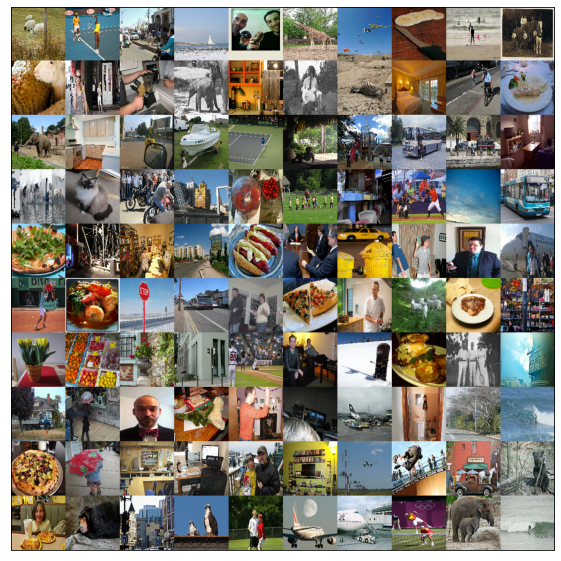

In [9]:
# original data
make_gallery(batch.numpy(), 10, epoch, 'orig', color_mode, save_path, save)

In [10]:
def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

(100, 128, 128, 3)


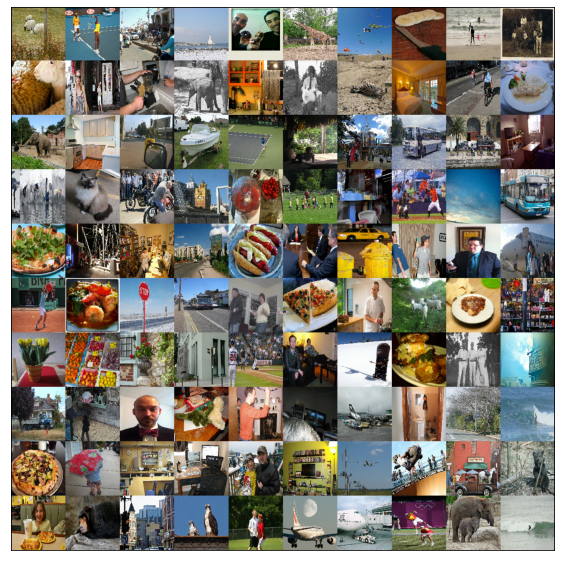

In [11]:
im = interval_mapping(images.numpy(), -1.0, 1.0, 0.0, 1.0)
print(im.shape)

# predictions from test data
make_gallery(im, 10, epoch, 'pred', color_mode, save_path, save)


image: 0


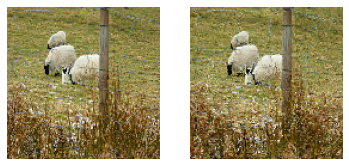

mse: tf.Tensor(0.011711814122405007, shape=(), dtype=float64)

image: 1


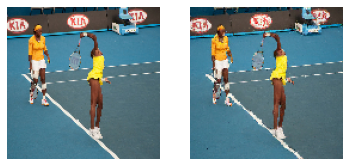

mse: tf.Tensor(0.0041662662622239804, shape=(), dtype=float64)

image: 2


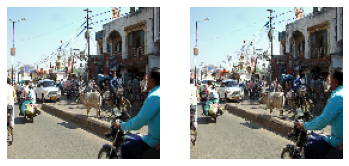

mse: tf.Tensor(0.010549968976558483, shape=(), dtype=float64)

image: 3


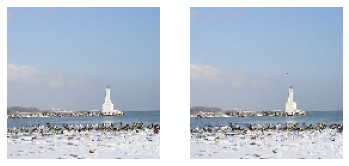

mse: tf.Tensor(0.004205135901492216, shape=(), dtype=float64)

image: 4


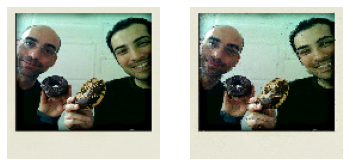

mse: tf.Tensor(0.002805265675185051, shape=(), dtype=float64)

image: 5


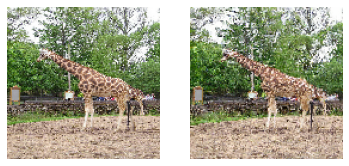

mse: tf.Tensor(0.02112799055368525, shape=(), dtype=float64)

image: 6


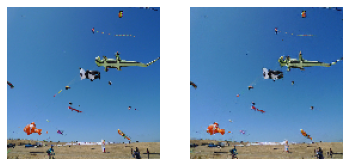

mse: tf.Tensor(0.002395135596819139, shape=(), dtype=float64)

image: 7


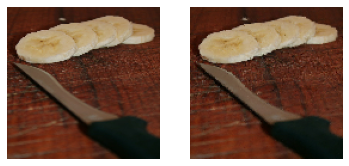

mse: tf.Tensor(0.0007192627112594602, shape=(), dtype=float64)

image: 8


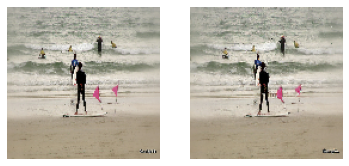

mse: tf.Tensor(0.0024204571289405718, shape=(), dtype=float64)

image: 9


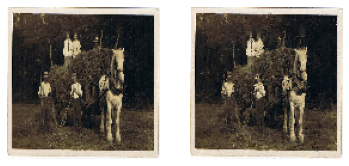

mse: tf.Tensor(0.0035702308729683814, shape=(), dtype=float64)

image: 10


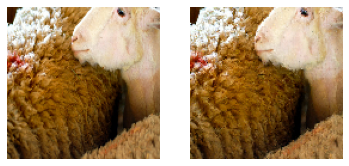

mse: tf.Tensor(0.003334865947645717, shape=(), dtype=float64)

image: 11


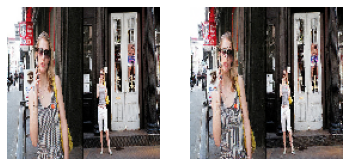

mse: tf.Tensor(0.007998356944598653, shape=(), dtype=float64)

image: 12


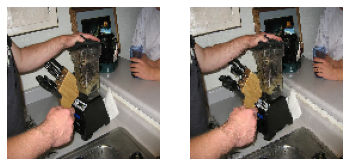

mse: tf.Tensor(0.003971789412679743, shape=(), dtype=float64)

image: 13


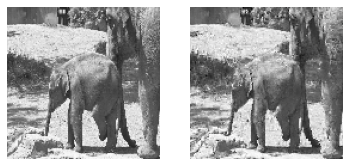

mse: tf.Tensor(0.006102866077483907, shape=(), dtype=float64)

image: 14


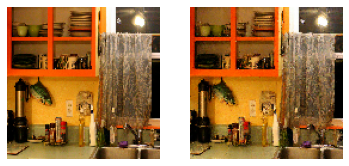

mse: tf.Tensor(0.00406884508057344, shape=(), dtype=float64)

image: 15


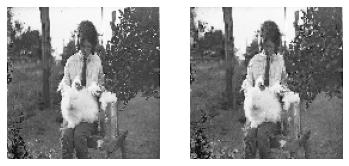

mse: tf.Tensor(0.005796665635711004, shape=(), dtype=float64)

image: 16


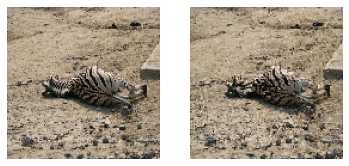

mse: tf.Tensor(0.010739776145332286, shape=(), dtype=float64)

image: 17


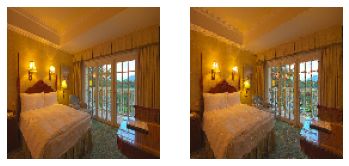

mse: tf.Tensor(0.002596578717910872, shape=(), dtype=float64)

image: 18


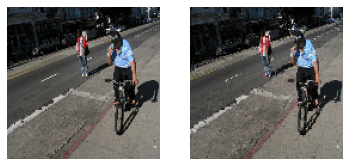

mse: tf.Tensor(0.004465956676856717, shape=(), dtype=float64)

image: 19


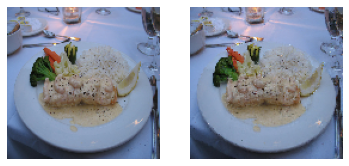

mse: tf.Tensor(0.0018191379759131354, shape=(), dtype=float64)


In [12]:
for i in range(20):
    print('\nimage:', i)
    draw2(batch[i], im[i], color_mode, save_path, save, epoch, 'comp')
    print('mse:', tf.reduce_mean(tf.keras.losses.mean_squared_error(batch[i], im[i])))